In [1]:
# CIS 569 Project 2 Clustering code
# Ben Pfeffer, Andrew Anctil, Rui Zhou


# Import required libraries
import os
import glob
import json

# Initialize data storage
names = []
texts = []

# Iterate through files, if not correct file (.txt extension) then skip, otherwise add to correct location in dictionary
for infile in glob.glob(os.path.join("./dataset", '*')):
    if(infile.endswith(".txt")):
        continue
    review_file = open(infile,'r').read()
    subKey = infile.split("/")[-1]
    mainKey = subKey.split("_")[0]
    names.append(subKey)
    texts.append(review_file)

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benjaminpfeffer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/benjaminpfeffer/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import collections

In [4]:
# Get English stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Process data and make list of list of words
textFull = []
for text in texts:
    currText = text.lower()
    tokens = word_tokenize(currText)
    
    # Remove stopwords
    no_stop = [w for w in tokens if w not in stopwords]
    
    # Remove punctuation
    no_punct = [w for w in no_stop if w.isalnum()]
    
    # Remove single characters
    no_single = [w for w in no_punct if len(w)>1]
    
    # Lemmatize (stemming, but more meaningful and more computationally expensive)
    # Initialize wordnet lemmatizer
    wnl = WordNetLemmatizer()

    # Perform lemmatization
    lemmatized = [wnl.lemmatize(w, pos="v") for w in no_single]
    
    # Append to list of list of words
    textFull.append(lemmatized)

In [5]:
# Make list of all documents for use in tf-idf matrix
textListFull = []
for textList in textFull:
    textListFull.append(" ".join(textList))

In [6]:
# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(textListFull)

# Get the shape, matches 111 documents given as data
print(tfidf_matrix.shape)

(111, 1867)


In [7]:
# Store the features for insight later
features = vectorizer.get_feature_names()

/Users/benjaminpfeffer/no/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


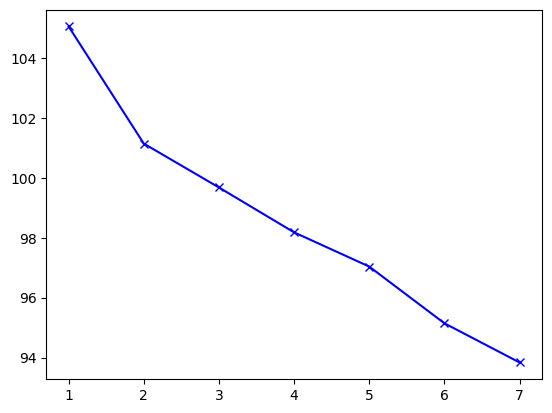

In [8]:
import matplotlib.pyplot as plt
# Perform the elbow method: 2 seems best, but for our visualization purposes let's use the next best: 4 clusters
Sum_of_squared_distances = []
K = range(1,8)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=1) # 349
    kmeans.fit(tfidf_matrix)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')

plt.show()

SilhouetteVisualizer(ax=<AxesSubplot: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4))

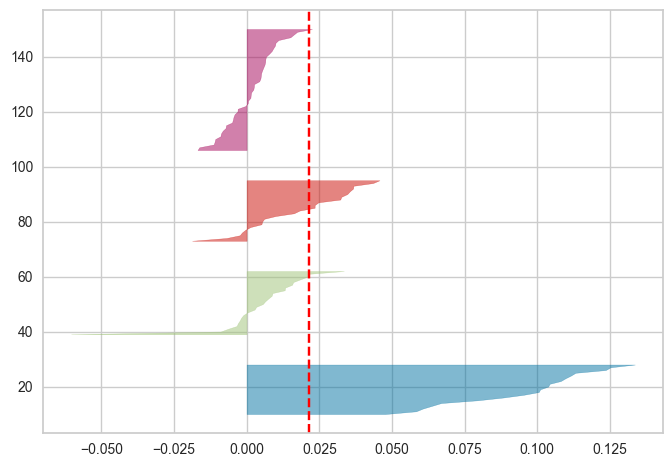

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
  

km = KMeans(n_clusters=4)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(tfidf_matrix) 

In [10]:
# Cluster the tf-idf matrix with the decided 4 clusters
num_clusters = 4
km = KMeans(n_clusters=num_clusters, random_state=1)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [11]:
# Store the clusters as a dataframe
clusterDf = pd.DataFrame()
clusterDf["File"] = names
clusterDf["Text"] = texts
clusterDf["Cluster"] = clusters

In [12]:
import re
# Create a function to tokenize by sentence and word, and limit results to alphanumeric tokens
def tokenize(text):
    # Tokenize by sentence and word
    word_tokens = [word.lower() for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)]
    final = []
    for val in word_tokens:
        # Remove words based on regex
        if re.search('[a-zA-Z0-9]', val):
            final.append(val)
    return final

In [13]:
# Get a list -> dataframe of all words used for reference in insight
total_words = []
for i in textListFull:
    words = tokenize(i)
    total_words.extend(words)
words = pd.DataFrame({'words': total_words}, index = total_words)

In [14]:
# Display the top terms per cluster and the titles of the documents in each cluster
print("Top terms per cluster:")
print()
# Sort cluster centers by proximity to centroid
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster", i, "words:")
    
    for idx in ordered_centroids[i, :10]: # Best 10 words per cluster
        print(words.loc[features[idx].split(' ')].values.tolist()[0][0], end=", ")
    print()
    print()
    
    print("Cluster", i, "titles:")
    for title in clusterDf.set_index("Cluster").loc[i]['File'].values.tolist():
        print(title, end=", ")
    print()
    print()

Top terms per cluster:

Cluster 0 words:
al, name, 2003, say, texas, know, london, shamrani, qaeda, identify, 

Cluster 0 titles:
CIA_08, CIA_37, CIA_06, FBI_10, FBI_28, FBI_17, FBI_21, FBI_19, USCBP_02, CIA_07, FBI_11, NSA_02, FBI_02, CIA_40, FBI_05, CIA_14, FBI_04, FBI_03, FBI_35, FBI_32, CIA_15, CIA_12, FBI_13, FBI_25, FBI_22, CIA_02, FBI_23, FBI_12, FBI_15, CIA_32, NSA_01, DIA_02, CIA_10, CIA_19, FBI_37, FBI_06, FBI_01, CIA_20, CIA_11, FBI_07, FBI_38, FBI_09, 

Cluster 1 words:
source, hanif, nassau, december, men, 2004, cairo, say, safrygin, package, 

Cluster 1 titles:
CIA_01, CIA_39, CIA_38, CIA_09, CIA_36, CIA_31, FBI_29, FBI_16, FBI_33, CIA_13, CIA_41, CIA_24, CIA_34, CIA_05, FBI_40, FBI_24, FBI_41, USCBP_01, CIA_04, CIA_35, NSA_06, CIA_28, CIA_26, FBI_39, CIA_43, CIA_29, CIA_42, 

Cluster 2 words:
call, phone, caller, say, intercept, receiver, location, chitral, tampico, bogota, 

Cluster 2 titles:
NSA_20, NSA_18, NSA_11, NSA_16, NSA_17, NSA_10, NSA_19, NSA_21, NSA_03, NSA_05

In [15]:
# Labels: threats, source information, communications, reports

In [16]:
# Convert from cluster dataframe to dictionary
clustDict = {}
for i in range(len(clusterDf)):
    cNum = str(clusterDf.iloc[i].Cluster)
    doc = clusterDf.iloc[i].File
    text = clusterDf.iloc[i].Text
    try:
        clustDict[cNum][doc] = text
    except:
        clustDict[cNum] = {}
        clustDict[cNum][doc] = text
clustDict = dict(collections.OrderedDict(sorted(clustDict.items())))

In [17]:
# Export dictionary to json file
with open('Project2Data.json', 'w') as fp:
    json.dump(clustDict, fp)